# Instacart Product Recommender
**Michael Feeley**  
**Metis Bootcamp - Project 4**

**=====================================================================**

# Modeling

**=====================================================================**

### -----------------------

## Imports

### -----------------------

In [23]:
# Loading the data
import pickle
import os

# Obligatory
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Metrics
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score, roc_auc_score

# Model tuning
import imblearn.over_sampling
from sklearn.preprocessing import StandardScaler

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

In [3]:
# The path for the repo
path = path = "/".join(os.getcwd().split('/')[0:-1])

# Unpacking the data
with open(f'{path}/pickles/df_ml.pkl', 'rb') as file:
    df_ml = pickle.load(file)

### -----------------------

## Metrics

### -----------------------

### F1, Precision, Recall

In [4]:
def score_model(model, X_test, y_test):
    '''
    Returns the F1, precision, and recall scores for a model.
    '''

    # F1
    f1 = f1_score(y_test, model.predict(X_test))
    
    # Precision
    precision = precision_score(y_test, model.predict(X_test))
    
    # Recall
    recall = recall_score(y_test, model.predict(X_test))
    print(f"{type(model).__name__}\n")
    print(f"F1:        {f1}")
    print(f"Precision: {precision}")
    print(f"Recall:    {recall}")
    generate_cm(y_test, model.predict(X_test))

### Confusion Matrix

In [5]:
def generate_cm(y_test, y_preds):
    '''
    Generates a colorful confusion matrix
    given a test set and a prediction set.
    '''
    
    cm = confusion_matrix(y_test, y_preds)
    sns.set(font_scale=1.4)
    sns.heatmap(
        cm,
        cmap=plt.cm.Reds,
        annot=True,
        fmt='.9g',
        linewidths=1,
        linecolor='black',
        cbar=True,
        xticklabels=['Not In Next Order\n\nPredicted',
                     'In Next Order\n\nPredicted'],
        yticklabels=['Actual\n\nNot In Next Order',
                     'Actual\n\nIn Next Order'],
        mask=None,
        ax=None,
    );

### -----------------------

## Preprocessing

### -----------------------

#### Train Test Split

In [6]:
def get_train_test_split(df, scale = True, test_size = .2, seed = 42):
    '''
    Custom train_test split that accounts for user overlap.
    No user in the train set will be in the test set.
    '''
    rs = np.random.RandomState(seed)
    
    total_users = df['user_id'].unique()
    test_users = rs.choice(total_users,
                           size = int(total_users.shape[0] * test_size),
                           replace = False)
    
    df_train = df[~df['user_id'].isin(test_users)]
    df_test = df[df['user_id'].isin(test_users)]
    
    y_train, y_test = df_train['TARGET'], df_test['TARGET']
    X_train = df_train.drop(['product_id','user_id','TARGET'], axis = 1)
    X_test = df_test.drop(['product_id','user_id','TARGET'], axis = 1)
    
    # Standard scaler
    if scale:
        # Scale the data
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)
    
    return X_train, X_test, y_train, y_test

#### Over Sampler (Class Imbalance)

In [7]:
def over_sampler(X_train, y_train, pos_scaler = 1, neg_scaler = 1):
    '''
    Accounts for a class imbalance in 
    data by oversampling the negative class.
    '''
    
    # Counts the total number of positive and negative targets
    n_pos = np.sum(y_train == 1)
    n_neg = np.sum(y_train == 0)
    
    # Set up the ratio
    ratio = {1: n_pos * pos_scaler, 0: n_neg * neg_scaler}
    
    # Create random sampler object based on the above ratio
    ros = imblearn.over_sampling.RandomOverSampler(ratio = ratio, random_state = 42)
    
    # Generate oversampled data
    X_train_os, y_train_os = ros.fit_sample(X_train, y_train)
    
    # Return oversampled data
    return X_train_os, y_train_os

### -----------------------

## Modeling

### -----------------------

In [24]:
def random_forest_model(X_train, y_train):
    '''
    Returns a random forest model for the data.
    '''
    # Fix the class imbalance
    X_train, y_train = over_sampler(X_train, y_train)
    
    # Create model instance and fit the data
    model_rf = RandomForestClassifier(class_weight = {1:4, 0:1})
    model_rf.fit(X_train, y_train)
    
    # Return the fitted model
    return model_rf

In [25]:
def logistic_regression_model(X_train, y_train):
    '''
    Returns a logistic regression model for the data.
    '''
    
    # Fix the class imbalance
    X_train, y_train = over_sampler(X_train, y_train)
    
    # Create model instance and fit the data
    model_lr = LogisticRegression(class_weight = {1:4, 0:1})
    model_lr.fit(X_train, y_train)
    
    # Return the fitted model
    return model_lr

### Generate the Logistic Regression and Random Forest Models

In [26]:
# Train test split of the dataset
X_train, X_test, y_train, y_test = get_train_test_split(df_ml)

# Fit the data to a random forest model
model_rf = random_forest_model(X_train, y_train)

# Fit the data to a logistic regression model
model_lr = logistic_regression_model(X_train, y_train)

### Model Scores

RandomForestClassifier

F1:        0.20889594916600476
Precision: 0.5433884297520661
Recall:    0.12930186823992135


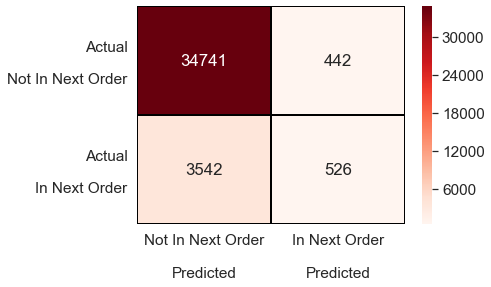

In [27]:
score_model(model_rf, X_test, y_test)

LogisticRegression

F1:        0.42180312787488505
Precision: 0.39628349178910977
Recall:    0.45083579154375614


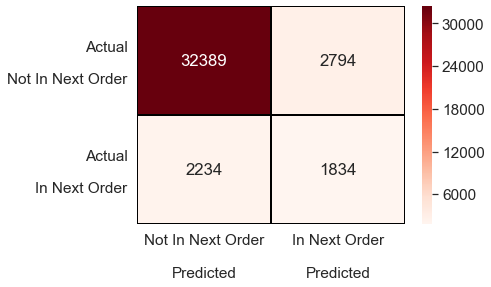

In [28]:
score_model(model_lr, X_test, y_test)